In [1]:
#import fdb
import json
import time
import datetime
import itertools
import numpy as np
import pandas as pd
#import networkx as nx
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

In [2]:
# plt.style.use('seaborn-whitegrid')
# plt.rcParams["figure.figsize"] = (10,8)
sns.set()

# Análise do Michael

In [3]:
class item_t:
    def __init__(self, procod, prodesrdz, itvvlrtot, grpcod, seccod, grpdes):
        self.procod = int(procod)
        self.prodesrdz = prodesrdz
        self.itvvlrtot = float(itvvlrtot)
        if isinstance(grpcod, str): # parse grpcod str to int
            grpcod = int(grpcod) if len(grpcod.strip()) > 0 else np.nan
        self.grpcod = grpcod
        self.seccod = int(seccod)
        self.grpdes = grpdes

    def __str__(self):
        return '%014d %-20s %5.2f %03d %02d %-30s' % (self.procod, self.prodesrdz, self.itvvlrtot, self.grpcod, self.seccod, self.grpdes)
    
    def __eq__(self, other):
        return self.procod == other.procod
    
    def __lt__(self, other):
        return self.procod < other.procod
    
    def to_dict(self):
        return {'procod':self.procod, 'prodesrdz':self.prodesrdz, 'itvvlrtot':self.itvvlrtot, 'grpcod':self.grpcod, 'seccod':self.seccod, 'grpdes':self.grpdes}

class cupom_t:
    def __init__(self, trndat, cxanum, trnseq):
        self.trndat = trndat
        self.cxanum = cxanum
        self.trnseq = trnseq        
        self.items = []        

    def append_item(self, item):
        self.items.append(item)

    def __str__(self):
        s = str(self.trndat) + (' %03d  %06d\n' % (self.cxanum, self.trnseq))
        for item in self.items:
            s += '   ' + str(item) + '\n'
        return s

    def __eq__(self, other):
        return self.trndat == other.trndat and self.cxanum == other.cxanum and self.trnseq == other.trnseq
    
    def join_items(self):
        """Join duplicated items (same procod) by adding itvvlrtot"""
        items = {}
        for item in self.items:
            if item.procod not in items:
                items[item.procod] = item
            else:
                items[item.procod].itvvlrtot += item.itvvlrtot
        self.items = items.values()
        
    def vlrtot(self):
        vlr = 0
        for item in items:
            vlr += item.itvvlrtot
        return vlr
        
    def to_dict(self):
        items = []
        for item in self.items:
            items.append(item.to_dict())
        return {'trndat':str(self.trndat), 'cxanum':self.cxanum, 'trnseq':self.trnseq, 'items':items}
    
    
def parse_cupons_from_fdb(cur):
    """Creates a list CUPONS of cupom_t objects and dictionary PRODES with prodesrdz for each procod."""
    print('parse_cupons')
    tic = time.time()
    CUPONS = []
    PRODES = {}
    for row in cur:
        cupom = cupom_t(row[0], int(row[1]), int(row[2]))        
        item = item_t(row[3], row[4], row[5], row[6], row[7], row[8])
        PRODES[item.procod] = {'prodesrdz':item.prodesrdz, 'grpdes':item.grpdes}
        if len(CUPONS) > 0 and CUPONS[-1] == cupom:
            cupom = CUPONS[-1] # using the last created cupom
        else:
            CUPONS.append(cupom) # add new cupom
        cupom.append_item(item)
    # removing duplicated items on the same cupom
    qtd_del_items = 0
    for cupom in CUPONS:
        len_old = len(cupom.items)
        cupom.join_items()
        qtd_del_items += len_old - len(cupom.items)
    print('   Duplicated items in cupom ... %d (removed)' % qtd_del_items)    
    print('   Number of cupons ............ %d' % len(CUPONS))
    print('   Number of unique procods .... %d' % len(PRODES))
    print('Time elapsed %3.2f secs' % (time.time() - tic))
    return CUPONS, PRODES

def dump_json(CUPONS, PRODES, fname):
    print('dump_json ' + fname)
    data = {'CUPONS':[cupom.to_dict() for cupom in CUPONS], 'PRODES':PRODES}
    tic = time.time()
    with open(fname, 'w') as fid:
        fid.write(json.dumps(data, sort_keys=True, indent=3))
    print('Time elapsed %3.2f secs' % (time.time() - tic))
    
def load_json(fname):
    print('load_json ' + fname)
    tic = time.time()
    with open(fname, 'r') as fid:
        data = json.loads(fid.read())
        cupons = data['CUPONS']
        prodes = data['PRODES']
    # parse cupons
    CUPONS = []
    for cupom in cupons:
        # parse string to datetime 2019-10-01 00:00:00        
        trndat = datetime.datetime.strptime(cupom['trndat'], '%Y-%m-%d %H:%M:%S')
        c = cupom_t(trndat, cupom['cxanum'], cupom['trnseq'])
        for item in cupom['items']:
            c.append_item(item_t(item['procod'], item['prodesrdz'], item['itvvlrtot'], item['grpcod'], item['seccod'], item['grpdes']))
        CUPONS.append(c)
    # parse prodes
    PRODES = {}
    for procod in prodes:
        PRODES[int(procod)] = prodes[procod]
    print('Time elapsed %3.2f secs' % (time.time() - tic))
    return CUPONS, PRODES

In [4]:
# deserialization from json
CUPONS, PRODES = load_json('data.json')
print('[TOP PRODES]')
for k, procod in enumerate(PRODES):
    print('   %08d %-20s %-30s' % (procod, PRODES[procod]['prodesrdz'], PRODES[procod]['grpdes']))
    if k > 4:
        break
print('\n[TOP CUPONS]')
for k, cupom in enumerate(CUPONS):
    print('%s' % str(cupom))
    if k > 4:
        break

load_json data.json
Time elapsed 1.02 secs
[TOP PRODES]
   00000250 PALIS NOBRE TABUADA  MATERIAL ESCOLAR              
   00000255 PAPEL CREPOM NOVA PR MATERIAL ESCOLAR              
   00000256 BORRACHA FALTANDO    MATERIAL ESCOLAR              
   00000257 TINTA P/ TECIDO ACRI MATERIAL ESCOLAR              
   00000263 FDA ADT BIGFRAL CONF HIGIENE CORPORAL              
   00000281 FUNIL COM ALCA PEQUE PLASTICOS                     

[TOP CUPONS]
2019-10-01 00:00:00 001  460297
   07897664130319 DET L MINUANO MR 500  1.49 001 06 LOUCA                         

2019-10-01 00:00:00 001  460298
   00000000001560 COSTELA PA           21.00 002 14 BOVINO CAIXARIA               
   00000000001661 CARRE SUINO KG       13.61 003 14 SUINOS                        
   00000000005478 LANC CHESTER PERDIGA  1.74 002 10 PRESUNTO                      
   07891132019281 TEMP SAZ FL CARN.60G  3.89 005 02 TEMPEROS                      
   07893000980006 MARG.DELINE 500G      7.98 004 09 MARGARINA     

2019-10-01 00:00:00 	month_day: 01	week_day: 02



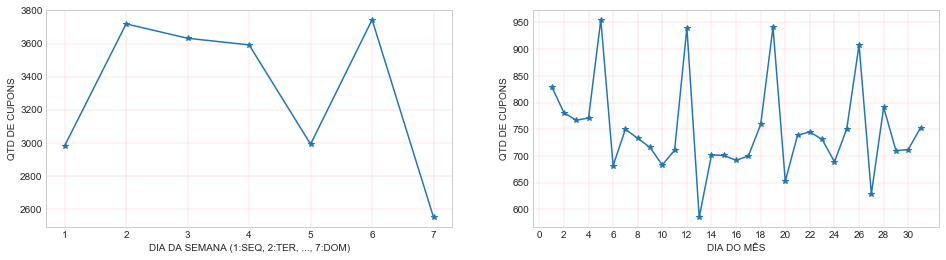

In [5]:
# calculating the number of cupons per day of week and month
qtd_week_day = np.zeros(7, dtype=int)
qtd_month_day = np.zeros(31, dtype=int)
print_first_day = True
for cupom in CUPONS:
    trndat = cupom.trndat
    qtd_week_day[trndat.weekday()] += 1
    qtd_month_day[trndat.day-1] += 1
    if trndat.day==1 and print_first_day:
        print_first_day = False
        print(trndat, '\tmonth_day: %02d\tweek_day: %02d' % (trndat.day, trndat.weekday()+1))

plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
x = np.arange(1, 8)
plt.plot(x,qtd_week_day,'-*')
plt.xlabel('DIA DA SEMANA (1:SEQ, 2:TER, ..., 7:DOM)')
plt.ylabel('QTD DE CUPONS')
plt.grid(color='r', linestyle='-', linewidth=0.1)

plt.subplot(1,2,2)
x = np.arange(1,len(qtd_month_day)+1)
plt.plot(x,qtd_month_day,'-*')
plt.xlabel('DIA DO MÊS')
plt.ylabel('QTD DE CUPONS')
plt.grid(color='r', linestyle='-', linewidth=0.1)
plt.xticks(np.arange(0, np.max(x), step=2))
print('')


mean(T): 6.098234, median(T): 3.000000, std(T): 8.800802


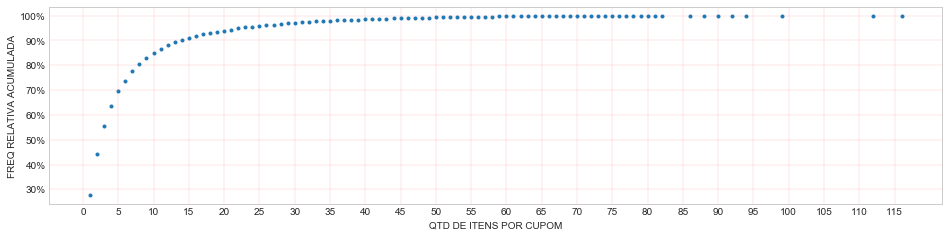

In [6]:
# histograma do numero de itens por cupom
T = [len(cupom.items) for cupom in CUPONS] #

from matplotlib.ticker import PercentFormatter

print('mean(T): %f, median(T): %f, std(T): %f' % (np.mean(T), np.median(T), np.std(T)))

plt.figure(figsize=(16,8))

Q = {q:0 for q in np.unique(T)}
for q in T:
    Q[q] += 1
x, y = sorted(Q.keys()), []
for q in Q:    
    y.append(Q[q])
y = np.cumsum(y) / np.sum(y)
plt.subplot(2,1,2)
plt.plot(x,y, '.')
plt.xlabel('QTD DE ITENS POR CUPOM')
plt.ylabel('FREQ RELATIVA ACUMULADA')
plt.xticks(np.arange(0, np.max(x), step=5))
plt.grid(color='r', linestyle='-', linewidth=0.1)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

In [7]:
# Calcutating the number of occurrencies (cupons) of each item.
# ITEM_QTD_VDA[procod] : number of occurrencies (cupons) of procod
ITEM_QTD_VDA = {procod:{'procod':procod, 'qtd':0} for procod in PRODES}
for cupom in CUPONS:
    for item in cupom.items:
        ITEM_QTD_VDA[item.procod]['qtd'] += 1
# convert dict to sorted list
ITEM_QTD_VDA = sorted(ITEM_QTD_VDA.values(), reverse=True, key=lambda u:u['qtd'])
print('RANK     PROCOD             ITEM                       GRPDES                QTD    FREQ(%)')
print('==== ============== =====================  ==============================  =======  ======')
N = len(CUPONS)
for k, item in enumerate(ITEM_QTD_VDA):
    procod = item['procod']
    print('[%02d] %014d %-20s   %-30s %6d     %4.2f' % (k+1, procod, PRODES[procod]['prodesrdz'], PRODES[procod]['grpdes'], item['qtd'], 100 * item['qtd']/N))
    if k == 9:
        break

RANK     PROCOD             ITEM                       GRPDES                QTD    FREQ(%)
==== ============== =====================  ==============================  =======  ======
[01] 00000000001044 CEBOLA BRANCA KG       LEGUMES                          2164     9.32
[02] 00000000001456 TOMATE EXTRA KG        FRUTAS                           1927     8.30
[03] 00000000001056 BATATA INGLESA KG      LEGUMES                          1483     6.39
[04] 00000000001024 PIMENTAO KG            LEGUMES                          1418     6.11
[05] 07896725200114 ACU OLHO D AGUA 1KG    ACUCAR                           1386     5.97
[06] 00000000003184 ARROZ BEM CASEIRO 1K   ARROZ                            1361     5.86
[07] 00000000001017 ALHO GRANDE KG         VERDURAS                         1330     5.73
[08] 07896510100094 LTE MARANG 1L INT      LEITE UHT                        1328     5.72
[09] 07896242200048 OLEO DE SOJA ABC 900   OLEOS                            1250     5.39
[10] 00

In [4]:
q = [item['qtd'] for item in ITEM_QTD_VDA]

plt.figure(figsize=(16,6))
plt.loglog(q, '.')
plt.xlabel('ITEM ID (SEQUENCIAL)')
plt.ylabel('NÚMERO DE CUPONS')
print('')

In [ ]:
q = np.array([item['qtd'] for item in ITEM_QTD_VDA])

plt.figure(figsize=(16,6))
plt.loglog(q/len(CUPONS), '.')
plt.xlabel('ITEM ID (SEQUENCIAL)')
plt.ylabel('FREQ REL EM CUPONS')
plt.grid(color='r', linestyle='-', linewidth=0.1)
print('')

# Agrupamento

In [3]:
jsonFile = open('data.json', 'r')
cupons_json = json.load(jsonFile)
jsonFile.close()

In [4]:
amostras = []
id_cupom = []
for cupom in cupons_json['CUPONS']:
    itens_amostra = []
    id_cupom.append(cupom['trnseq'])
    for item in cupom['items']:
        itens_amostra.append(item)
        
    amostras.append(itens_amostra)
    
categorias_amostra = []
for amostra in amostras:
    categorias = []
    for itens in amostra:
        categorias.append(itens['grpdes'])
    categorias_amostra.append(categorias)
    
categorias = set()
for amostras in categorias_amostra:
    categorias_ = np.unique(amostras)
    for i in categorias_:
        categorias.add(i)

In [5]:
df = pd.DataFrame(index=id_cupom,columns=categorias)
for i,index in enumerate(df.index):
    df.loc[index] = pd.get_dummies(categorias_amostra[i]).sum(axis=0)
    
df = df.fillna(0)

In [5]:
#df = pd.read_csv('matriz_cupom_grupo.csv',index_col='Cupom')
#df.head()

In [7]:
df_inicial = df.copy()
#df_inicial.to_csv('matriz_cupom_grupo.csv',index_label='Cupom')

In [8]:
df.head(10)

,ARROZ,POLPAS E DERIVADOS,REFRIGERANTES,AUTOMOTIVOS,COCADA,MACARRAO,CREME PARA PENTEAR,HIDRATANTE / OLEO INFANTIL,BISCOITO,FRUTAS,...,KIT FEMININO,MATERIAL DE INFORMATICA,RAPADURA,PISOS E ASSOALHOS,HAMBURGUES,CREME PENTEAR INFANTIL,BANHEIRO,FERMENTOS,LAVAGEM DE ROUPAS,RACAO P/CAES
Cupom,,,,,,,,,,,,,,,,,,,,,
460297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
460298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
460299,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
460300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
460301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
460302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
460303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
460304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
460305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
#Conferindo se o numero de itens bate mesmo
df.sum(axis=1)

Cupom
460297     1.0
460298    10.0
460299     4.0
460300     3.0
460301     1.0
          ... 
48579      5.0
48580      2.0
48581      1.0
48583      1.0
48584      1.0
Length: 23210, dtype: float64

In [11]:
df.shape

(23210, 178)

In [12]:
pca = PCA()
pca.fit(df)

PCA()

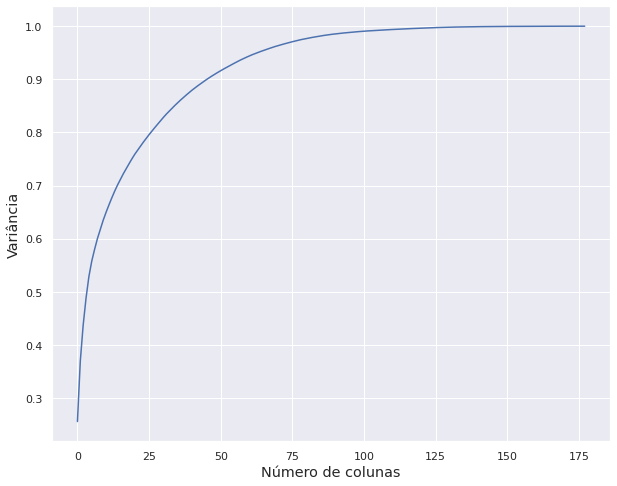

In [15]:
plt.figure(figsize=(10,8))
plt.xlabel('Número de colunas',size='large')
plt.ylabel('Variância',size='large')
plt.plot(pca.explained_variance_ratio_.cumsum())

In [13]:
#PCA com 90% da variância original
pca = PCA(0.90)
pca_samples = pca.fit_transform(df)
pca_df = pd.DataFrame(pca_samples,index=df.index)

In [19]:
pca_df.shape
#47 colunas

(23210, 47)

## K-means

In [25]:
# When K increases(n centroides), the centroids are closer to the clusters centroids.
# The improvements will decline, at some point rapidly, creating the elbow shape.
# That point is the optimal value for K.

distancias = []                         #Sum of squared distances of samples to their closest cluster center
clusters = list(range(1,101))
for i in clusters:
    k_means = KMeans(n_clusters=i,random_state=42)
    k_means.fit(pca_df)
    distancias.append(k_means.inertia_)
    if not(i%10): print('foi o',i)
  

foi o 10
foi o 20
foi o 30
foi o 40
foi o 50
foi o 60
foi o 70
foi o 80
foi o 90
foi o 100


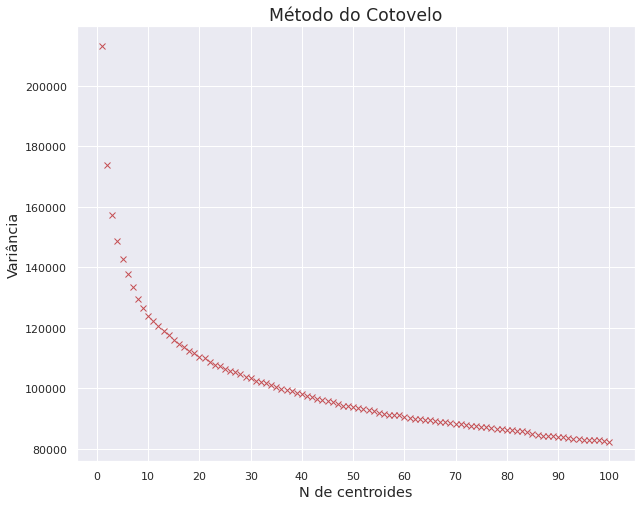

In [27]:
plt.figure(figsize=(10,8))
plt.title('Método do Cotovelo',size='x-large')
plt.xlabel('N de centroides',size='large')
plt.ylabel('Variância',size='large')
plt.xticks(list(range(0,101,10)))
plt.plot(clusters,distancias,'rx')

In [64]:
n_clusters=10
k_means = KMeans(n_clusters=n_clusters,random_state=42)
k_means.fit(pca_df)
c_preds = k_means.predict(pca_df)

In [65]:
df['cluster'] = c_preds
df.head()

,ARROZ,POLPAS E DERIVADOS,REFRIGERANTES,AUTOMOTIVOS,COCADA,MACARRAO,CREME PARA PENTEAR,HIDRATANTE / OLEO INFANTIL,BISCOITO,FRUTAS,...,RAPADURA,PISOS E ASSOALHOS,HAMBURGUES,CREME PENTEAR INFANTIL,BANHEIRO,FERMENTOS,LAVAGEM DE ROUPAS,RACAO P/CAES,aggcluster,cluster
Cupom,,,,,,,,,,,,,,,,,,,,,
460297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
460298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
460299,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
460300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
460301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1


In [66]:
df['cluster'].value_counts(normalize=False)

1    15076
5     2781
8     1532
2     1142
0      958
6      542
4      362
3      359
9      311
7      147
Name: cluster, dtype: int64

In [28]:
#Taxa de cada item em cada cluster
clusters = pd.DataFrame(index=range(n_clusters), columns=df.drop('cluster',axis=1).columns)
mean_clusters_kmeans = pd.DataFrame()
limiar = 0.3
print('Quantidade média de itens p/ cupons de cada cluster (> %.3lf)' % limiar)
for i in range(n_clusters):
    cluster_inf = df[df['cluster']==i].drop('cluster',axis=1)
    clusters.loc[i] = cluster_inf.sum() / len(cluster_inf.index)

    print('cluster %d' % i)
    clusters_limiar = clusters.loc[i,clusters.loc[i]>limiar].sort_values(ascending=False)
    mean_clusters_kmeans = pd.concat([mean_clusters_kmeans,clusters_limiar],axis=1)
    print(clusters_limiar)
    print('\n')
    
mean_clusters_kmeans = mean_clusters_kmeans.fillna(0,downcast='infer')

Quantidade média de itens p/ cupons de cada cluster (> 0.300)
cluster 0
TEMPEROS              1.09812
LAVAGEM DE ROUPAS    0.955115
ARROZ                0.946764
MACARRAO             0.822547
ACUCAR               0.672234
CAFE                 0.658664
BISCOITO             0.617954
FEIJAO                0.60334
MASSAS               0.551148
SABONETES            0.519833
LOUCA                0.504175
OLEOS                0.504175
MARGARINA            0.388309
LEGUMES               0.36952
LEITE PO             0.350731
FRUTAS               0.347599
LEITE UHT            0.339248
DIANTEIRO            0.321503
HIGIENE BUCAL        0.317328
Name: 0, dtype: object


cluster 1
Series([], Name: 1, dtype: object)


cluster 2
FRUTAS       2.76795
BISCOITO    0.434326
LEGUMES     0.391419
Name: 2, dtype: object


cluster 3
REFRESCOS             4.14763
BISCOITO              1.12256
TEMPEROS             0.682451
FRUTAS               0.626741
LEGUMES              0.582173
LAVAGEM DE ROUPAS    0.54317

In [29]:
 mean_clusters_kmeans.head(15)

,0,1,2,3,4,5,6,7,8,9
TEMPEROS,1.09812,0,0,0.682451,0.79558,0,0.50369,2.61224,0.3453,3.94534
LAVAGEM DE ROUPAS,0.955115,0,0,0.543175,0.828729,0,0.516605,2.37415,0,2.32154
ARROZ,0.946764,0,0,0.534819,0.538674,0,0.476015,1.14286,0,1.18971
MACARRAO,0.822547,0,0,0.526462,0.491713,0,0.625461,1.84354,0,1.45338
ACUCAR,0.672234,0,0,0.392758,0.381215,0,0.345018,0.863946,0,0.871383
CAFE,0.658664,0,0,0.37883,0.372928,0,0.335793,1.02041,0,0.958199
BISCOITO,0.617954,0,0.434326,1.12256,1.30939,1.34124,4.44834,7.71429,0,2.37299
FEIJAO,0.60334,0,0,0.337047,0,0,0.354244,0.938776,0,1.0836
MASSAS,0.551148,0,0,0.320334,0.39779,0,0.322878,1.0068,0,1.01608
SABONETES,0.519833,0,0,0.337047,0.356354,0,0.372694,1.63265,0,1.49839


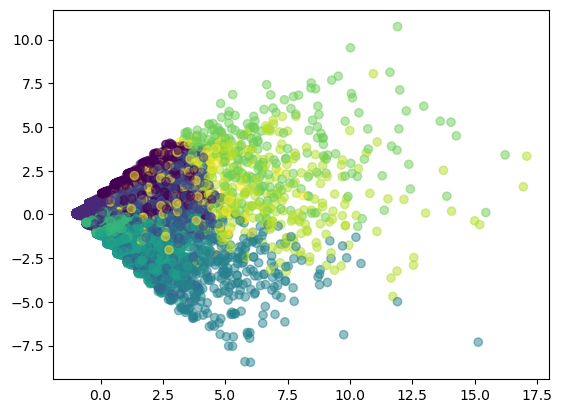

In [50]:
pca = PCA(n_components=2)
proj_r2 = pca.fit_transform(df.drop('cluster',axis=1))

plt.style.use('default')
plt.scatter(proj_r2[:,0], proj_r2[:,1], c=df.loc[:,'cluster'], alpha=0.5)
plt.show()

In [17]:
from sklearn.manifold import TSNE

In [24]:
tsne = TSNE(init='pca',random_state=42,n_jobs=3)
df_tsne = tsne.fit_transform(df)

<bound method Figure.savefig of <Figure size 1008x1008 with 1 Axes>>

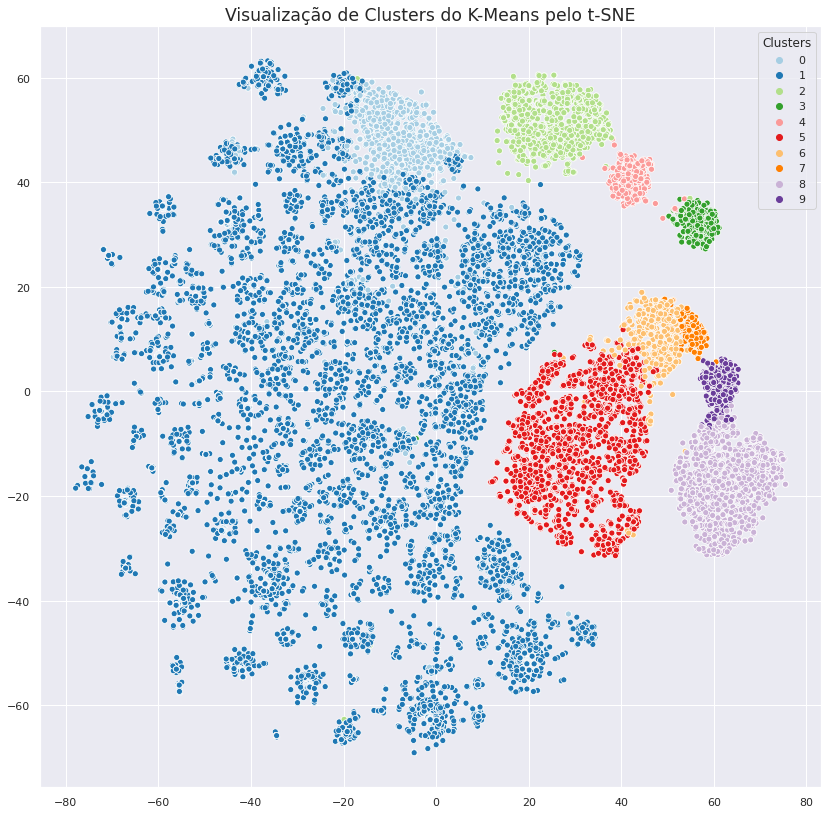

In [82]:
plt.figure(figsize=(14,14))
plt.title('Visualização de Clusters do K-Means pelo t-SNE',size='x-large')
g = sns.scatterplot(df_tsne[:,0],df_tsne[:,1],hue=c_preds,palette='Paired')
g.legend().set_title("Clusters")
g.get_figure().savefig('images/K_means_clusters.png')

## Hierarchical clustering

The AgglomerativeClustering object performs a hierarchical clustering using a bottom up approach: each observation starts in its own cluster, and clusters are successively merged together. The linkage criteria determines the metric used for the merge strategy:

> * **Ward** minimizes the sum of squared differences within all clusters. It is a variance-minimizing approach and in this sense is similar to the k-means objective function but tackled with an agglomerative hierarchical approach.
>
> * **Maximum** or **complete linkage** minimizes the maximum distance between observations of pairs of clusters.
>
> * **Average linkage** minimizes the average of the distances between all observations of pairs of clusters.
>
> * **Single linkage** minimizes the distance between the closest observations of pairs of clusters.

### _ward_ linkage | 10 clusters

In [30]:
df = df_inicial

In [33]:
n_clusters=10
agg_cluster = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward', distance_threshold=None)
agg_cluster.fit(pca_df)
c_preds = agg_cluster.labels_

In [34]:
df['aggcluster'] = c_preds
df.head()

,ARROZ,POLPAS E DERIVADOS,REFRIGERANTES,AUTOMOTIVOS,COCADA,MACARRAO,CREME PARA PENTEAR,HIDRATANTE / OLEO INFANTIL,BISCOITO,FRUTAS,...,MATERIAL DE INFORMATICA,RAPADURA,PISOS E ASSOALHOS,HAMBURGUES,CREME PENTEAR INFANTIL,BANHEIRO,FERMENTOS,LAVAGEM DE ROUPAS,RACAO P/CAES,aggcluster
Cupom,,,,,,,,,,,,,,,,,,,,,
460297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
460298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
460299,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
460300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
460301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [35]:
df['aggcluster'].value_counts(normalize=False)

1    16965
5     1837
6     1703
2      749
4      587
0      298
8      280
7      274
3      268
9      249
Name: aggcluster, dtype: int64

In [36]:
#Taxa de cada item em cada cluster
clusters = pd.DataFrame(index=range(n_clusters), columns=df.drop(['aggcluster'],axis=1).columns)
mean_clusters_ward = pd.DataFrame()
limiar = 0.3
print('Quantidade média de itens p/ cupons de cada cluster (> %.3lf)' % limiar)
for i in range(n_clusters):
    cluster_inf = df[df['aggcluster']==i].drop(['aggcluster'],axis=1)
    clusters.loc[i] = cluster_inf.sum() / len(cluster_inf.index)

    print('cluster %d' % i)
    clusters_limiar = clusters.loc[i,clusters.loc[i]>limiar].sort_values(ascending=False)
    mean_clusters_ward = pd.concat([mean_clusters_ward,clusters_limiar],axis=1)
    print(clusters_limiar)
    print('\n')

mean_clusters_ward = mean_clusters_ward.fillna(0,downcast='infer')

Quantidade média de itens p/ cupons de cada cluster (> 0.300)
cluster 0
BISCOITO                           5.46644
TEMPEROS                           2.81208
LAVAGEM DE ROUPAS                  2.39262
LOUCA                               1.8255
SABONETES                          1.62752
REFRESCOS                          1.59732
MACARRAO                           1.55034
LEGUMES                            1.51007
FRUTAS                              1.4396
ARROZ                              1.14094
FEIJAO                            0.993289
MASSAS                            0.983221
CAFE                              0.966443
HIGIENE BUCAL                      0.92953
IOGURTE                           0.902685
DIANTEIRO                         0.885906
ACUCAR                            0.838926
OLEOS                             0.828859
LEITE PO                          0.781879
MARGARINA                         0.738255
MINGAU                            0.687919
PAPEL HIGIENICO          

In [37]:
mean_clusters_ward.head(15)

,0,1,2,3,4,5,6,7,8,9
BISCOITO,5.46644,0,0.818425,2.11194,1.12266,1.55634,0.3165,1.77007,4.93929,0.538153
TEMPEROS,2.81208,0,0,2.13806,1.81942,0,0.461538,0.828467,0.360714,0.309237
LAVAGEM DE ROUPAS,2.39262,0,0,1.96642,1.4753,0,0,0.682482,0.392857,0
LOUCA,1.8255,0,0,1.61194,0.827939,0,0,0.419708,0,0
SABONETES,1.62752,0,0,0.895522,0.79046,0,0,0.452555,0,0
REFRESCOS,1.59732,0,0,0.414179,0,0,0,4.10949,0,0
MACARRAO,1.55034,0,0,1.08209,0.890971,0,0,0.627737,0.407143,0
LEGUMES,1.51007,0,0.435247,4.1791,0.475298,0,2.52378,0.437956,0.385714,3.91566
FRUTAS,1.4396,0,3.22296,3.09701,0.531516,0,1.0963,0.664234,0.642857,4.14859
ARROZ,1.14094,0,0,0.970149,0.959114,0,0,0.631387,0,0


### _complete_ linkage | 10 clusters
_single_ linkage yields similar results

In [38]:
df = df_inicial

In [39]:
n_clusters=10
agg_cluster = AgglomerativeClustering(n_clusters=n_clusters, linkage='complete', distance_threshold=None)
agg_cluster.fit(pca_df)
c_preds = agg_cluster.labels_

In [40]:
df['aggcluster'] = c_preds
df.head()

,ARROZ,POLPAS E DERIVADOS,REFRIGERANTES,AUTOMOTIVOS,COCADA,MACARRAO,CREME PARA PENTEAR,HIDRATANTE / OLEO INFANTIL,BISCOITO,FRUTAS,...,MATERIAL DE INFORMATICA,RAPADURA,PISOS E ASSOALHOS,HAMBURGUES,CREME PENTEAR INFANTIL,BANHEIRO,FERMENTOS,LAVAGEM DE ROUPAS,RACAO P/CAES,aggcluster
Cupom,,,,,,,,,,,,,,,,,,,,,
460297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
460298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
460299,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
460300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
460301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [41]:
df['aggcluster'].value_counts(normalize=False)

0    21153
5     1803
2       90
4       50
3       49
6       33
7       11
1       11
9        8
8        2
Name: aggcluster, dtype: int64

In [42]:
#Taxa de cada item em cada cluster
clusters = pd.DataFrame(index=range(n_clusters), columns=df.drop(['aggcluster'],axis=1).columns)
mean_clusters_complete = pd.DataFrame()
limiar = 0.3
print('Quantidade média de itens p/ cupons de cada cluster (> %.3lf)' % limiar)
for i in range(n_clusters):
    cluster_inf = df[df['aggcluster']==i].drop(['aggcluster'],axis=1)
    clusters.loc[i] = cluster_inf.sum() / len(cluster_inf.index)

    print('cluster %d' % i)
    clusters_limiar = clusters.loc[i,clusters.loc[i]>limiar].sort_values(ascending=False)
    mean_clusters_complete = pd.concat([mean_clusters_complete,clusters_limiar],axis=1)
    print(clusters_limiar)
    print('\n')

mean_clusters_complete = mean_clusters_complete.fillna(0,downcast='infer')

Quantidade média de itens p/ cupons de cada cluster (> 0.300)
cluster 0
BISCOITO    0.371531
Name: 0, dtype: object


cluster 1
BISCOITO                           8.45455
REFRESCOS                          6.81818
TEMPEROS                           4.63636
LEGUMES                            3.45455
FRUTAS                             2.81818
MACARRAO                           2.63636
LAVAGEM DE ROUPAS                  1.90909
SABONETES                          1.63636
DIANTEIRO                          1.63636
MASSAS                             1.45455
LOUCA                              1.27273
IOGURTE                            1.27273
ARROZ                              1.27273
ENLATADOS                          1.27273
FEIJAO                             1.09091
ACUCAR                             1.09091
HIGIENE BUCAL                      1.09091
CAFE                               1.09091
MINGAU                            0.909091
SALGADOS/APERITIVOS               0.818182
BOMBONIERE  

In [43]:
mean_clusters_complete.head(15)

,0,1,2,3,4,5,6,7,8,9
BISCOITO,0.371531,8.45455,6.23333,9.32653,2.66,0.59401,3.51515,8.90909,4,0
REFRESCOS,0,6.81818,1.11111,0.408163,1.2,0,0.575758,0.727273,3.5,0
TEMPEROS,0,4.63636,2.74444,0.959184,6.46,0.488075,2.09091,6.72727,5,0.625
LEGUMES,0,3.45455,2.04444,1.16327,2.44,2.95785,4.09091,5.09091,8,0.875
FRUTAS,0,2.81818,1.62222,2.2449,2.1,2.16805,5.72727,5.81818,11,0.375
MACARRAO,0,2.63636,1.7,1.34694,1.64,0,1.36364,2.45455,0.5,0
LAVAGEM DE ROUPAS,0,1.90909,2.74444,1.57143,2.38,0.340544,3.72727,3.81818,1.5,0
SABONETES,0,1.63636,1.56667,1.22449,2.72,0,1.42424,1.45455,1.5,0
DIANTEIRO,0,1.63636,0.811111,0.653061,0.9,0.357737,1.06061,1.72727,2,0
MASSAS,0,1.45455,1.04444,0.530612,1.24,0,0.848485,1.36364,1,0


### _ward_ linkage | distance threshold (euclidian)

In [45]:
df = df_inicial

In [46]:
agg_cluster = AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=50.0)
agg_cluster.fit(pca_df)
c_preds = agg_cluster.labels_

In [47]:
df['aggcluster'] = c_preds
df.head()

,ARROZ,POLPAS E DERIVADOS,REFRIGERANTES,AUTOMOTIVOS,COCADA,MACARRAO,CREME PARA PENTEAR,HIDRATANTE / OLEO INFANTIL,BISCOITO,FRUTAS,...,MATERIAL DE INFORMATICA,RAPADURA,PISOS E ASSOALHOS,HAMBURGUES,CREME PENTEAR INFANTIL,BANHEIRO,FERMENTOS,LAVAGEM DE ROUPAS,RACAO P/CAES,aggcluster
Cupom,,,,,,,,,,,,,,,,,,,,,
460297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
460298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
460299,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
460300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
460301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


In [48]:
df['aggcluster'].value_counts(normalize=False)

5     15071
11     1837
2      1703
6      1438
0       749
4       587
12      456
8       280
7       274
1       268
9       249
3       228
10       70
Name: aggcluster, dtype: int64

In [49]:
#Taxa de cada item em cada cluster
clusters = pd.DataFrame(index=range(agg_cluster.n_clusters_), columns=df.drop(['aggcluster'],axis=1).columns)
mean_clusters_ward_euclidian = pd.DataFrame()
limiar = 0.3
print('Quantidade média de itens p/ cupons de cada cluster (> %.3lf)' % limiar)
for i in range(agg_cluster.n_clusters_):
    cluster_inf = df[df['aggcluster']==i].drop(['aggcluster'],axis=1)
    clusters.loc[i] = cluster_inf.sum() / len(cluster_inf.index)

    print('cluster %d' % i)
    clusters_limiar = clusters.loc[i,clusters.loc[i]>limiar].sort_values(ascending=False)
    mean_clusters_ward_euclidian = pd.concat([mean_clusters_ward_euclidian,clusters_limiar],axis=1)
    print(clusters_limiar)
    print('\n')

mean_clusters_ward_euclidian = mean_clusters_ward_euclidian.fillna(0,downcast='infer')

Quantidade média de itens p/ cupons de cada cluster (> 0.300)
cluster 0
FRUTAS       3.22296
BISCOITO    0.818425
LEGUMES     0.435247
IOGURTE     0.332443
Name: 0, dtype: object


cluster 1
LEGUMES                             4.1791
FRUTAS                             3.09701
TEMPEROS                           2.13806
BISCOITO                           2.11194
LAVAGEM DE ROUPAS                  1.96642
LOUCA                              1.61194
MACARRAO                           1.08209
ARROZ                             0.970149
DIANTEIRO                         0.895522
SABONETES                         0.895522
VERDURAS                          0.768657
CAFE                              0.761194
FEIJAO                            0.731343
MASSAS                            0.712687
ACUCAR                            0.708955
MARGARINA                         0.615672
IOGURTE                           0.593284
LEITE PO                          0.593284
OLEOS                             0

In [50]:
mean_clusters_ward_euclidian.head(15)

,0,1,2,3,4,5,6,7,8,9,10,11,12
FRUTAS,3.22296,3.09701,1.0963,1,0.531516,0,0,0.664234,0.642857,4.14859,2.87143,0,0
BISCOITO,0.818425,2.11194,0.3165,4.4693,1.12266,0,0,1.77007,4.93929,0.538153,8.71429,1.55634,0
LEGUMES,0.435247,4.1791,2.52378,1.07018,0.475298,0,0,0.437956,0.385714,3.91566,2.94286,0,0
IOGURTE,0.332443,0.593284,0,0.802632,0.316865,0,0,0.427007,0.578571,0.353414,1.22857,0.327164,0
TEMPEROS,0,2.13806,0.461538,2.81579,1.81942,0,0,0.828467,0.360714,0.309237,2.8,0,0
LAVAGEM DE ROUPAS,0,1.96642,0,2.37281,1.4753,0,0,0.682482,0.392857,0,2.45714,0,0
LOUCA,0,1.61194,0,1.94737,0.827939,0,0,0.419708,0,0,1.42857,0,0
MACARRAO,0,1.08209,0,1.51316,0.890971,0,0.545202,0.627737,0.407143,0,1.67143,0,0
ARROZ,0,0.970149,0,1.12719,0.959114,0,0.642559,0.631387,0,0,1.18571,0,0
DIANTEIRO,0,0.895522,0.372871,0.802632,0.422487,0,0,0.361314,0,0,1.15714,0,0


### _average_ linkage | distance threshold (manhattan)

In [51]:
df = df_inicial

In [52]:
agg_cluster = AgglomerativeClustering(n_clusters=None, linkage='average', affinity='manhattan', distance_threshold=50.0)
agg_cluster.fit(df)
c_preds = agg_cluster.labels_

In [53]:
df['aggcluster'] = c_preds
df.head()

,ARROZ,POLPAS E DERIVADOS,REFRIGERANTES,AUTOMOTIVOS,COCADA,MACARRAO,CREME PARA PENTEAR,HIDRATANTE / OLEO INFANTIL,BISCOITO,FRUTAS,...,MATERIAL DE INFORMATICA,RAPADURA,PISOS E ASSOALHOS,HAMBURGUES,CREME PENTEAR INFANTIL,BANHEIRO,FERMENTOS,LAVAGEM DE ROUPAS,RACAO P/CAES,aggcluster
Cupom,,,,,,,,,,,,,,,,,,,,,
460297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
460298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
460299,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
460300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
460301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [55]:
df['aggcluster'].value_counts(normalize=False)

0     22955
6        63
1        35
28       13
9         7
      ...  
71        1
63        1
23        1
70        1
55        1
Name: aggcluster, Length: 92, dtype: int64

In [56]:
#Taxa de cada item em cada cluster
clusters = pd.DataFrame(index=range(agg_cluster.n_clusters_), columns=df.drop(['aggcluster'],axis=1).columns)
mean_clusters_average = pd.DataFrame()
limiar = 0.3
print('Quantidade média de itens p/ cupons de cada cluster (> %.3lf)' % limiar)
for i in range(agg_cluster.n_clusters_):
    cluster_inf = df[df['aggcluster']==i].drop(['aggcluster'],axis=1)
    clusters.loc[i] = cluster_inf.sum() / len(cluster_inf.index)

    print('cluster %d' % i)
    clusters_limiar = clusters.loc[i,clusters.loc[i]>limiar].sort_values(ascending=False)
    mean_clusters_average = pd.concat([mean_clusters_average,clusters_limiar],axis=1)
    print(clusters_limiar)
    print('\n')

mean_clusters_average = mean_clusters_average.fillna(0,downcast='infer')

Quantidade média de itens p/ cupons de cada cluster (> 0.300)
cluster 0
FRUTAS      0.409453
BISCOITO     0.40257
LEGUMES     0.365803
Name: 0, dtype: object


cluster 1
REFRESCOS                          4.45714
BISCOITO                           3.37143
LAVAGEM DE ROUPAS                  2.82857
TEMPEROS                           2.82857
LOUCA                              2.42857
MACARRAO                           1.54286
SABONETES                          1.54286
ARROZ                              1.42857
FRUTAS                                 1.4
LEGUMES                            1.37143
MASSAS                             1.34286
FEIJAO                             1.31429
HIGIENE BUCAL                      1.05714
OLEOS                             0.942857
DIANTEIRO                         0.885714
ACUCAR                            0.885714
CAFE                              0.885714
LEITE PO                          0.857143
MARGARINA                         0.857143
PAPEL HIGIENI

BISCOITO                          8
TEMPEROS                          7
FRUTAS                            6
LAVAGEM DE ROUPAS                 4
ABSORVENTE                        4
SALGADOS/APERITIVOS               4
MANICURE                          4
SABONETES                         3
HIGIENE BUCAL                     3
LEGUMES                           3
CEREAL LIGHT/GRANOLAS             3
FEIJAO                            3
MACARRAO                          2
LOUCA                             2
SUINOS                            2
SHAMPOOS                          2
ARROZ                             2
DESODORANTES                      2
CREME DE LEITE/LEITE CONDENSAD    2
HIGIENE CORPORAL                  2
DIANTEIRO                         2
MARGARINA                         2
FUBAS/GRAOS                       1
REFRIGERANTES                     1
QUEIJOS                           1
CREME PARA PENTEAR                1
BEB LACTEA PRONTAS                1
SANDALIAS                   

cluster 58
BISCOITO                          9
FRUTAS                            7
LEGUMES                           7
TEMPEROS                          6
LOUCA                             4
LAVAGEM DE ROUPAS                 3
BOVINO CAIXARIA                   3
MASSAS                            3
OLEOS                             2
BANHEIRO                          2
ARROZ                             2
ENLATADOS                         2
SABONETES                         2
MARGARINA                         1
LINGUICA                          1
MACARRAO                          1
HAMBURGUES                        1
RAPADURA                          1
HIGIENE BUCAL                     1
QUEIJOS                           1
CREME DE LEITE/LEITE CONDENSAD    1
SALSICHA/SALSICHA LIGHT           1
ACUCAR                            1
LEITE UHT                         1
FRALDAS DESCARTAVEIS              1
MINGAU                            1
MOVEIS                            1
FARINHAS         

ENLATADOS                         5
TEMPEROS                          5
BISCOITO                          4
LEGUMES                           4
LOUCA                             4
LAVAGEM DE ROUPAS                 3
SABONETES                         3
REFRESCOS                         3
HIGIENE CAPILAR                   3
PRODUTOS DO LAR                   2
ACUCAR                            1
PAES                              1
CREME DE TRATAMENTO               1
LEITE UHT                         1
SALSICHA/SALSICHA LIGHT           1
FEIJAO                            1
VERDURAS                          1
HIGIENE BUCAL                     1
MACARRAO                          1
REFRIGERANTES                     1
OLEOS                             1
PEIXES                            1
CAFE                              1
SHAMPOOS                          1
BANHEIRO                          1
FRANGO                            1
MAIONESE/REQUEIJAO LIGHT          1
DESODORANTES                

In [57]:
mean_clusters_average.head(15)

,0,1,2,3,4,5,6,7,8,9,...,82,83,84,85,86,87,88,89,90,91
FRUTAS,0.409453,1.4,6,0.5,4.8,3,4.49206,0.5,2,1.71429,...,7,1,2,5,0,4,2,2,0,4
BISCOITO,0.40257,3.37143,4.66667,5.75,9,5,3.49206,7.5,3,2,...,6,10,5,7,14.5,7,12,4,4,2
LEGUMES,0.365803,1.37143,5,1.75,5,5.5,3.47619,2.5,2,3.57143,...,7,2,1.75,1,0,0,3,2,4,0
REFRESCOS,0,4.45714,1,1.5,0,2.25,0.412698,0,6.5,1.71429,...,0,0,1,4,0,2,4,4,3,4
LAVAGEM DE ROUPAS,0,2.82857,0.666667,0.5,2.6,1.5,1.98413,3.5,1.5,3.14286,...,4,0,1,2,3.5,2,2,1,3,5
TEMPEROS,0,2.82857,3.66667,6.75,1.6,3.5,2.66667,3,2.5,2.42857,...,2,6,2.75,5,4.5,4,2,9,5,5
LOUCA,0,2.42857,1.66667,0.5,1.2,1.25,1.52381,1.5,0.5,2.85714,...,5,2,2.5,2,2.5,3,1,4,4,5
MACARRAO,0,1.54286,1.33333,2.5,1.6,1.75,1.65079,3.5,0,0.857143,...,1,3,2,1,2.5,2,1,2,1,1
SABONETES,0,1.54286,1.66667,0.75,1,0.5,1.39683,0.5,3,1.57143,...,0,0,1.25,1,2,3,3,4,3,3
ARROZ,0,1.42857,1,1,1.2,1.75,1.06349,0.5,1,1.14286,...,1,1,0.75,1,1.5,1,1,2,1,1


## Visualizações dos Clusters

In [58]:
clusters_dfs = [mean_clusters_kmeans, mean_clusters_ward, mean_clusters_complete]

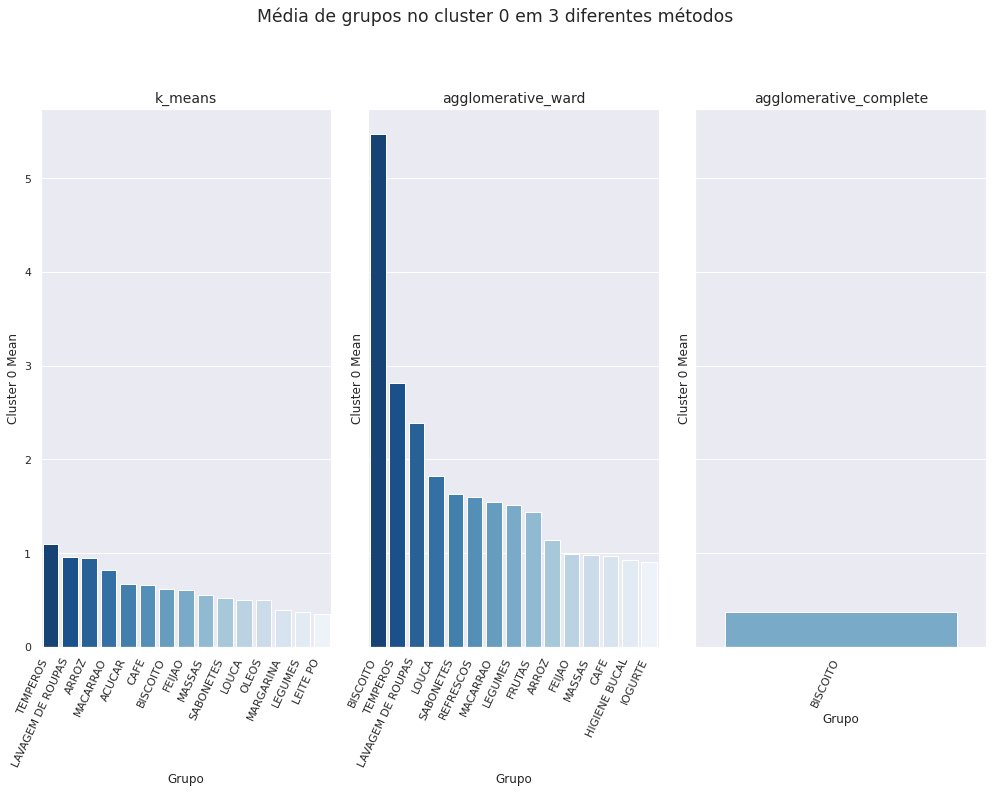

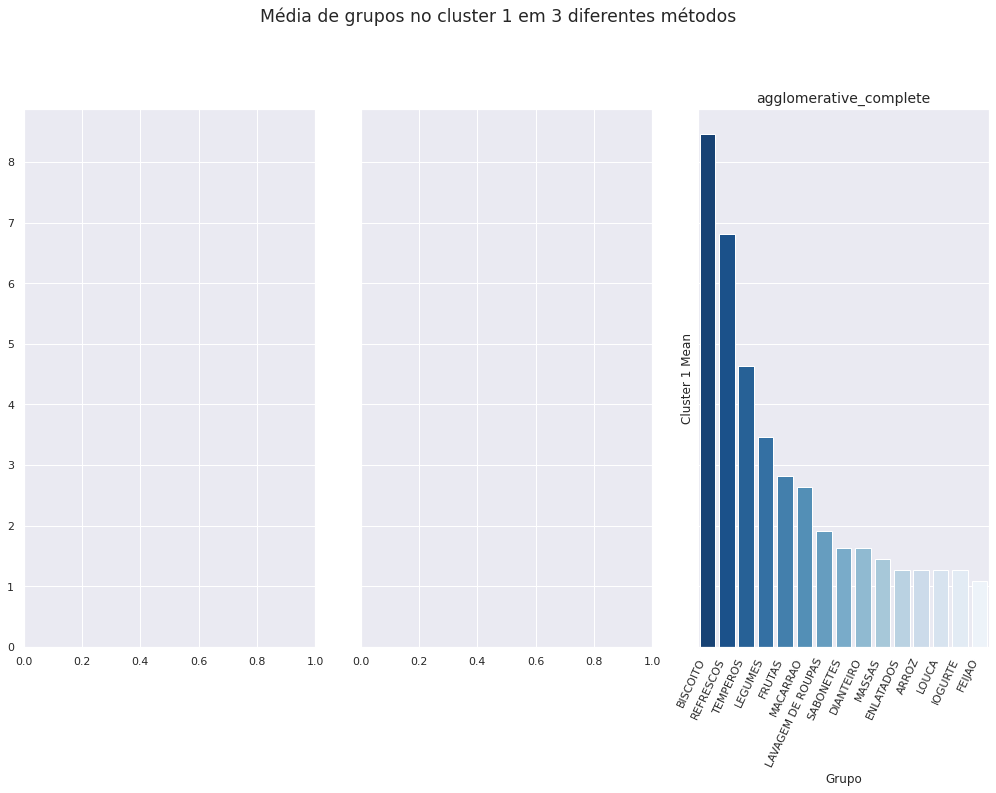

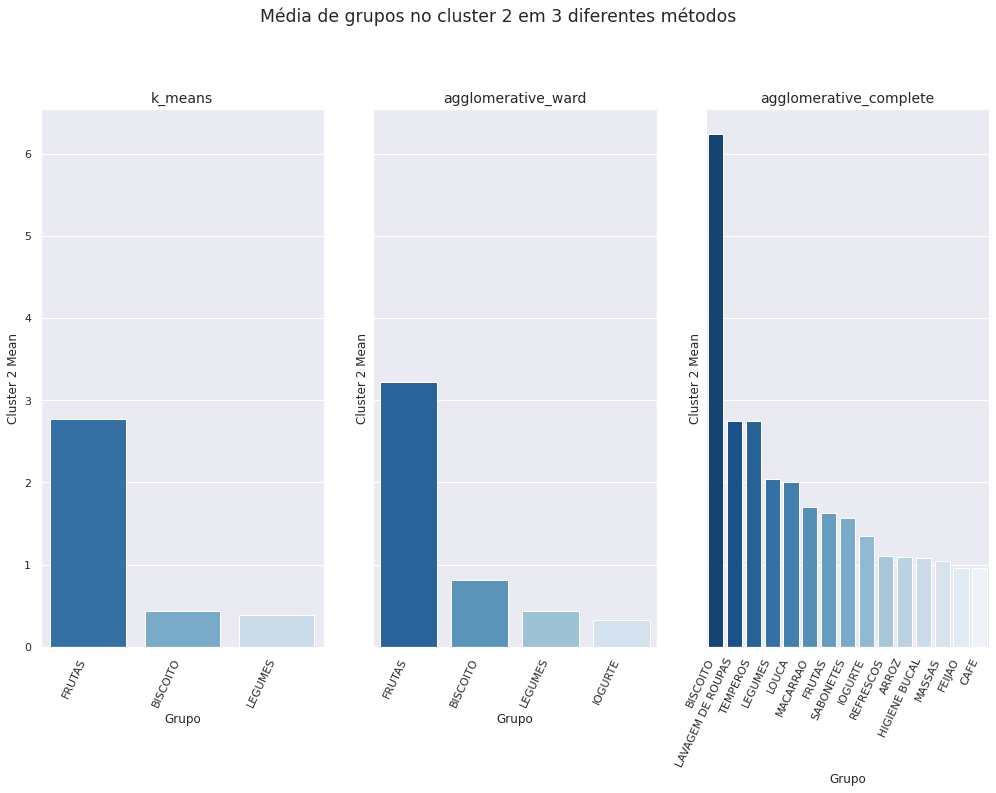

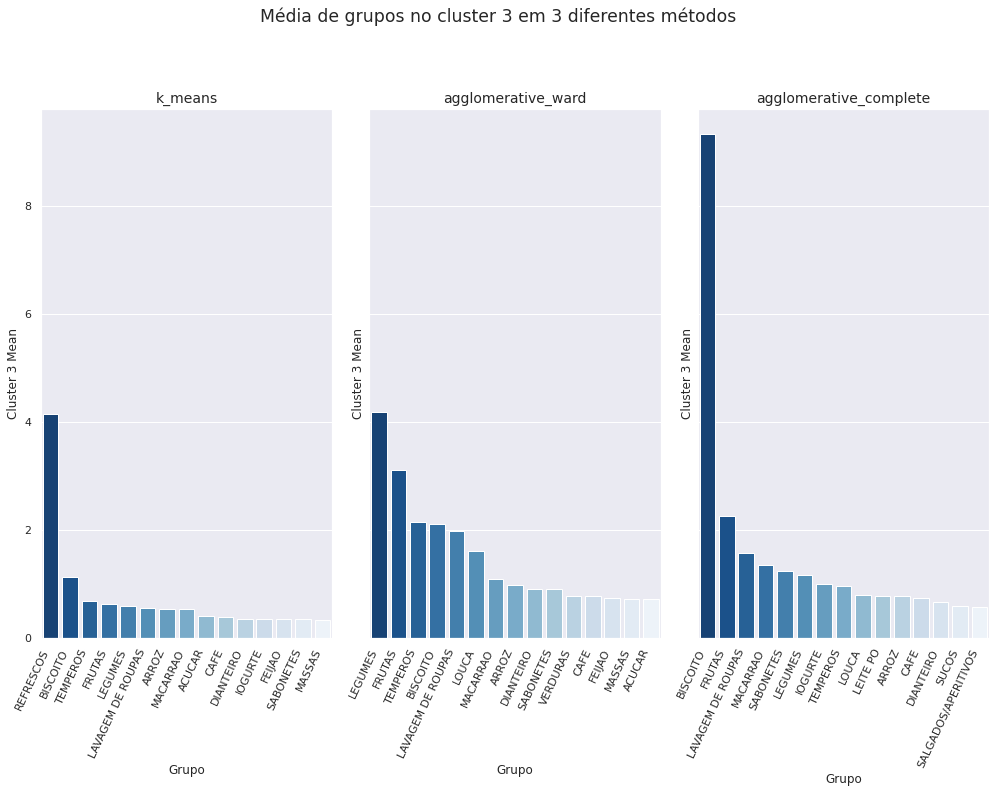

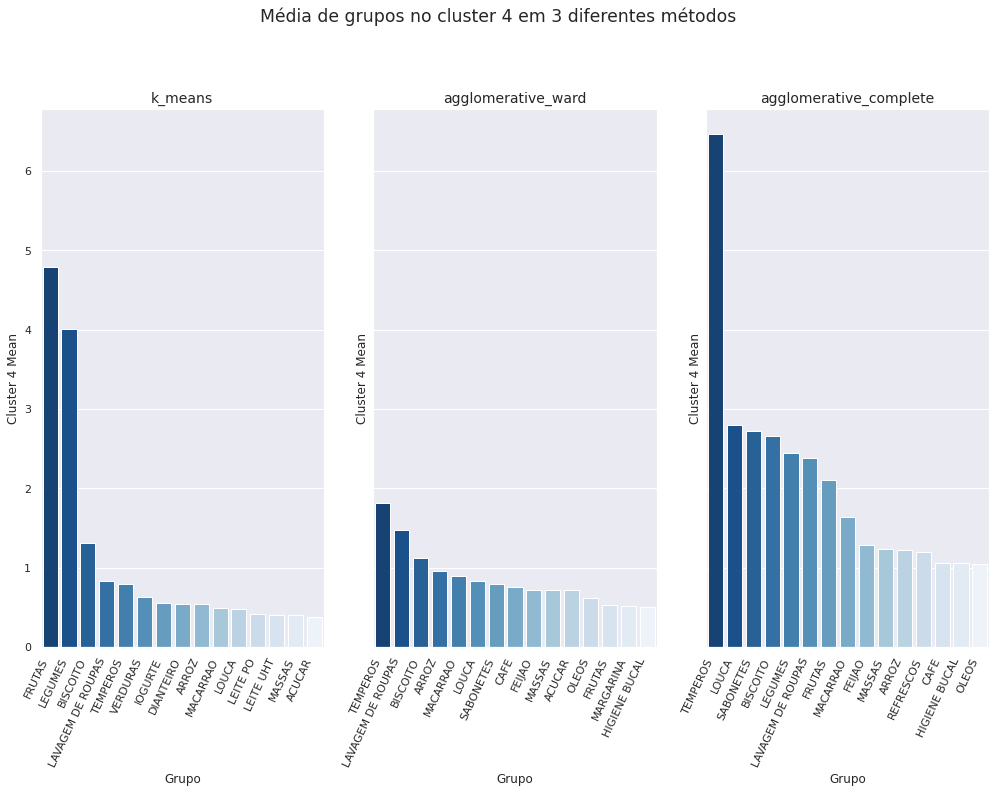

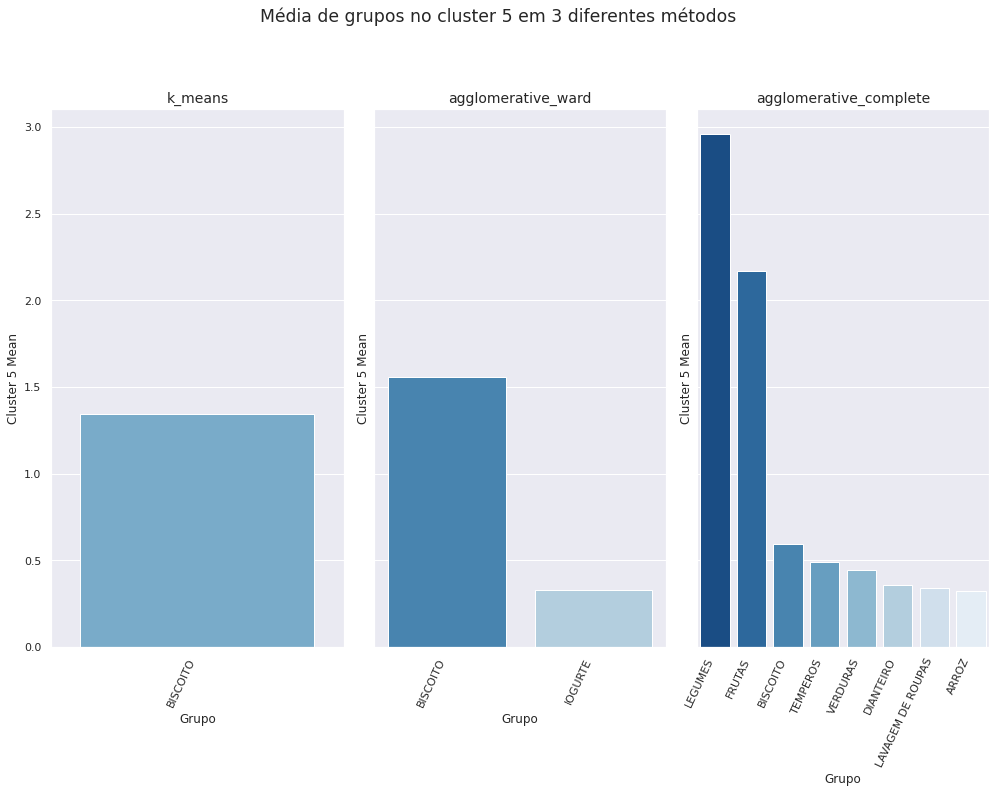

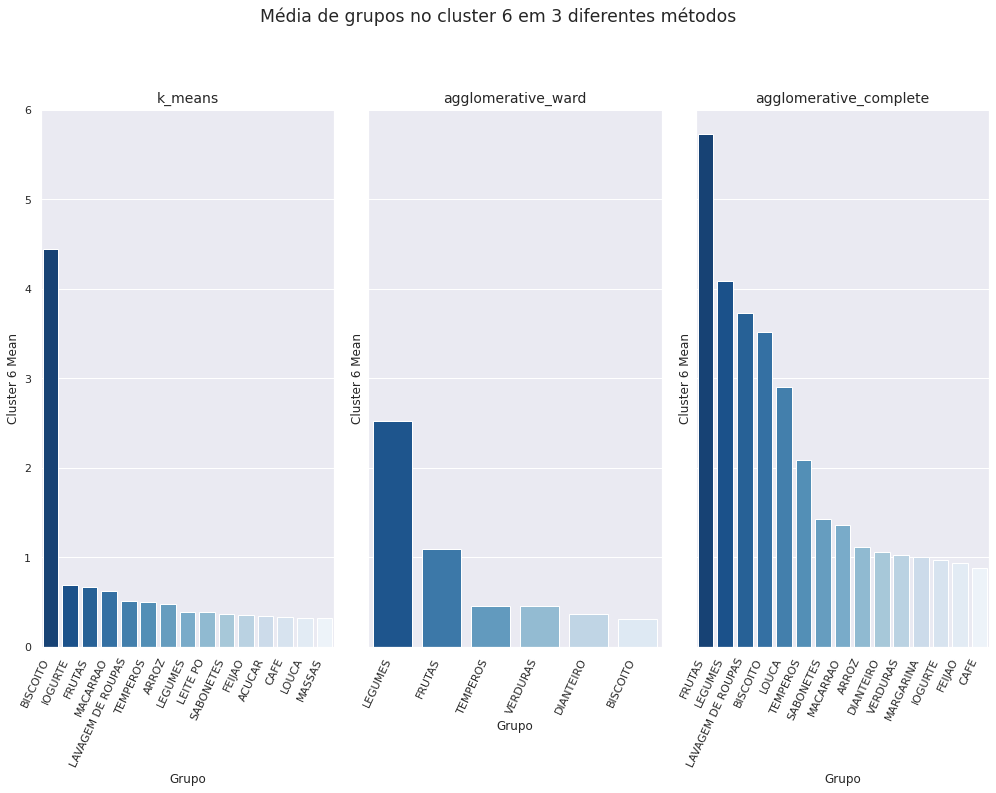

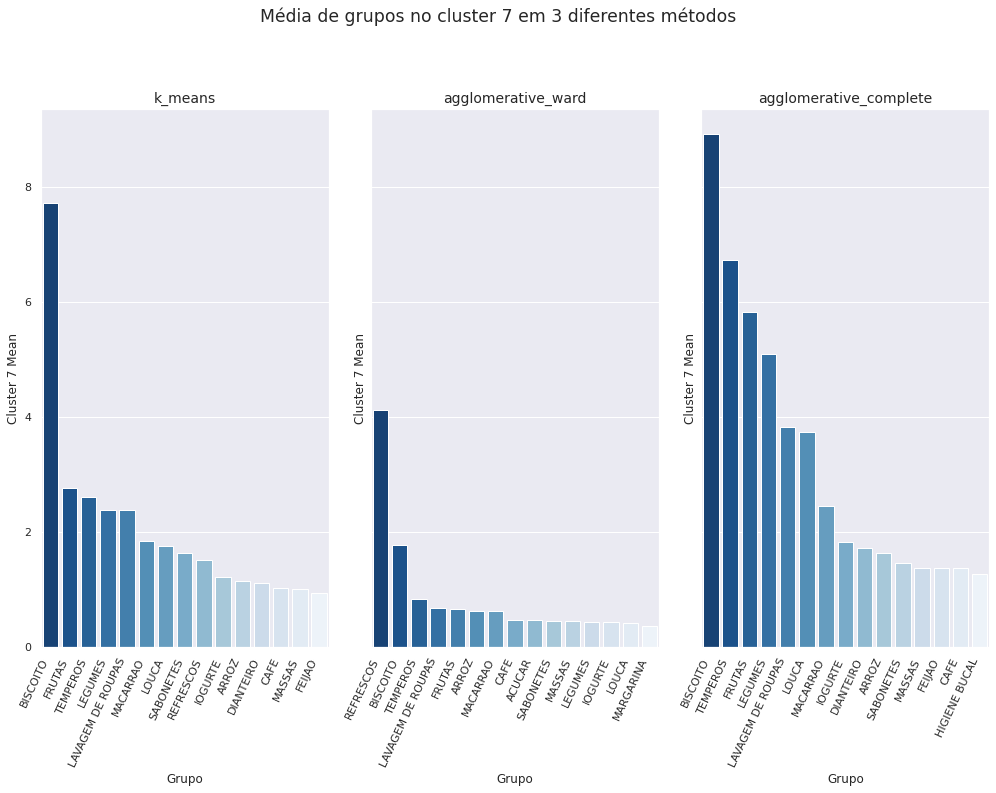

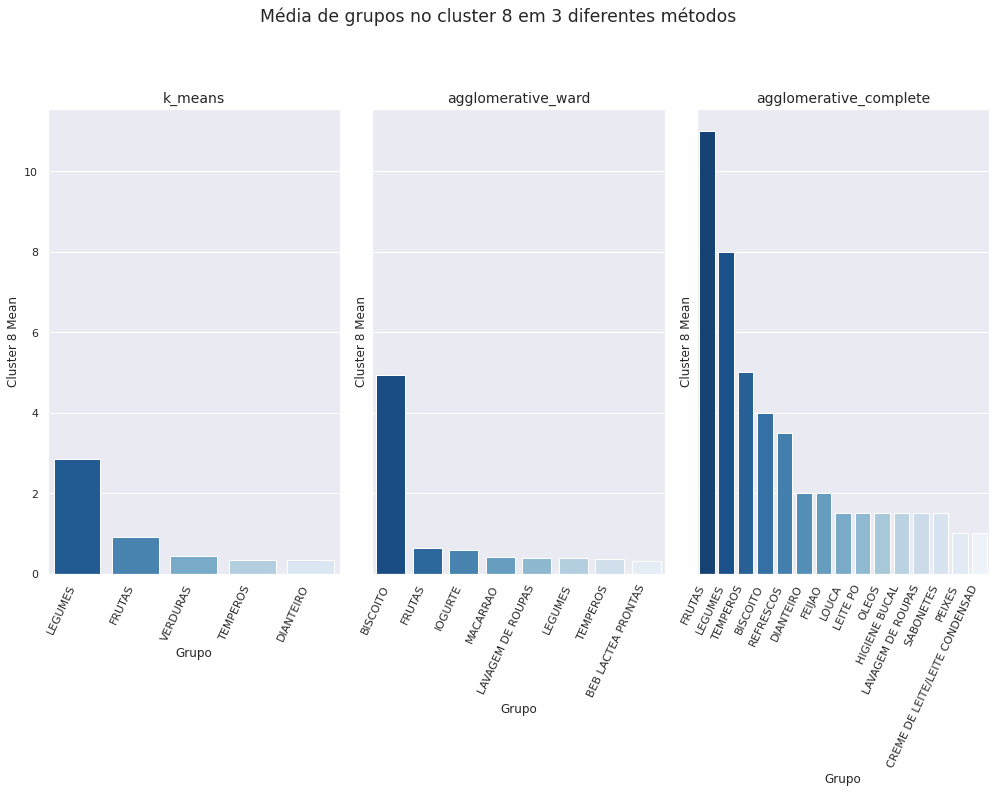

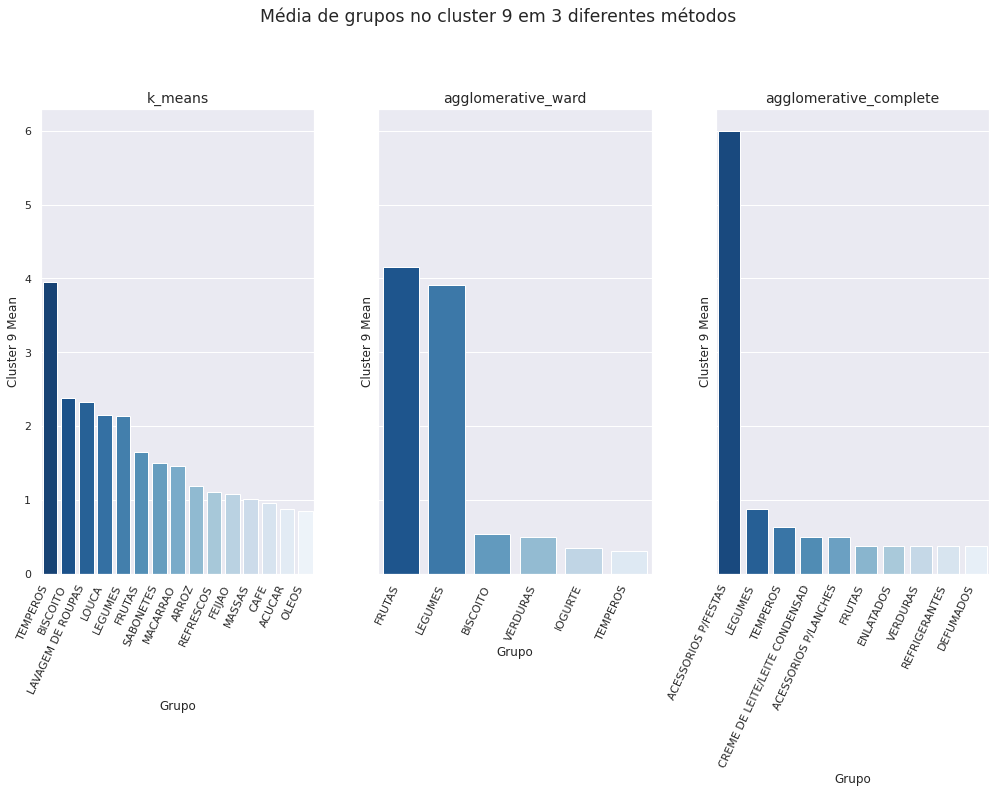

In [59]:
methods = ['k_means','agglomerative_ward','agglomerative_complete']
for i in range(10):
    fig,axes = plt.subplots(1,3,figsize=(14,10),sharey=True)
    fig.suptitle(f'Média de grupos no cluster {i} em 3 diferentes métodos',y = 1.1,size='x-large')

    for j,cluster_df in enumerate(clusters_dfs):
        no_zeros_cluster = cluster_df[i][cluster_df[i] != 0].reset_index().rename(columns={'index':'Grupo',i:f'Cluster {i} Mean'})
    
        if no_zeros_cluster[f'Cluster {i} Mean'].empty:
            continue
            
        no_zeros_cluster = no_zeros_cluster.sort_values(by = f'Cluster {i} Mean',ascending=False)
        if no_zeros_cluster.shape[0] > 15:
            no_zeros_cluster = no_zeros_cluster.iloc[:15,:]
        sns.barplot(data=no_zeros_cluster,x='Grupo',y=f'Cluster {i} Mean',palette='Blues_r',ci=None,log=False,ax=axes[j])
        axes[j].set_xticklabels(axes[j].get_xticklabels(), rotation = 65, ha="right")
        axes[j].set_title(methods[j], fontsize=14)

    plt.tight_layout()
    plt.savefig(f'images/cluster_{i}.png',bbox_inches='tight')